In [1]:
import pickle
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from gensim import corpora, models, similarities
from itertools import product
from operator import add

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
data = pickle.load(open('../data/processed/processed_data.p'))
data_lab = pickle.load(open('../data/processed/processed_data_lab.p'))
data_con = pickle.load(open('../data/processed/processed_data_con.p'))
data_libdem = pickle.load(open('../data/processed/processed_data_libdem.p'))
data_sou = pickle.load(open('../data/processed/processed_data_sou.p'))

text = data['text']
text_lab = data_lab['text']
text_con = data_con['text']
text_libdem = data_libdem['text']
text_sou = data_sou['text']

In [4]:
def doc_embedding(text):
    # tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    text = [tokenizer.tokenize(txt.lower()) for txt in text]
    
    # remove stop words
    stop = set(stopwords.words('english'))
    stop.add('applause')
    stop.add('us')
    stop.add('one')
    stop.add('cheers')
    stop.add('laughter')
    stop.add('hear')
    stop.add('madam')
    stop.add('mrs')
    stop.add('cent')
    stop.add('ed')
    stop.add('say')
    
    text = [[token for token in txt if token not in stop] for txt in text]
    
    # remove single count words
    c = Counter()
    [c.update(txt) for txt in text]
    text = [[token for token in txt if c[token] > 1] for txt in text]
    
    # create dictionary word -> id
    dictionary = corpora.Dictionary(text)
    
    # one hot document encoding
    corpus = [dictionary.doc2bow(txt) for txt in text]
    
#     # log entropy
#     log_ent = models.LogEntropyModel(corpus)
#     corpus_log_ent = log_ent[corpus]
    
    # tfidf model
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    # lsi model
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100)
    corpus_lsi = lsi[corpus]
    
    return dictionary, corpus, corpus_tfidf, corpus_lsi, tfidf, lsi, c

In [5]:
dictionary, corpus, corpus_tfidf, corpus_lsi, tfidf, lsi, c = doc_embedding(text)
dictionary_lab, corpus_lab, corpus_tfidf_lab, corpus_lsi_lab, tfidf_lab, lsi_lab, c_lab = doc_embedding(text_lab)
dictionary_con, corpus_con, corpus_tfidf_con, corpus_lsi_con, tfidf_con, lsi_con, c_con = doc_embedding(text_con)
dictionary_libdem, corpus_libdem, corpus_tfidf_libdem, corpus_lsi_libdem, tfidf_libdem, lsi_libdem, c_libdem = doc_embedding(text_libdem)
dictionary_sou, corpus_sou, corpus_tfidf_sou, corpus_lsi_sou, tfidf_sou, lsi_sou, c_sou = doc_embedding(text_sou)

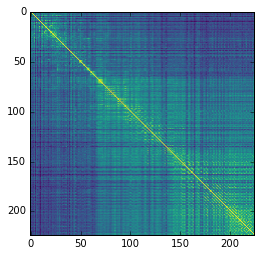

In [12]:
index = similarities.MatrixSimilarity(corpus_lsi)
sims = np.array([index[lsi[corp]] for corp in corpus])
plt.imshow(sims,cmap=plt.cm.viridis)

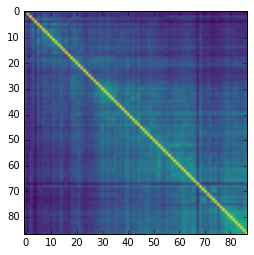

In [13]:
index_con = similarities.MatrixSimilarity(corpus_lsi_con)
sims_con = np.array([index_con[lsi_con[corp]] for corp in corpus_con])
plt.imshow(sims_con,cmap=plt.cm.viridis)

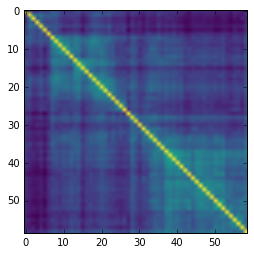

In [14]:
index_lab = similarities.MatrixSimilarity(corpus_lsi_lab)
sims_lab = np.array([index_lab[lsi_lab[corp]] for corp in corpus_lab])
plt.imshow(sims_lab,cmap=plt.cm.viridis)

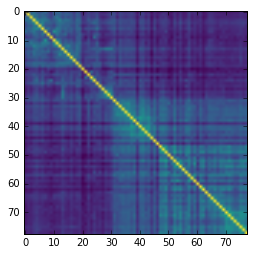

In [15]:
index_libdem = similarities.MatrixSimilarity(corpus_lsi_libdem)
sims_libdem = np.array([index_libdem[lsi_libdem[corp]] for corp in corpus_libdem])
plt.imshow(sims_libdem,cmap=plt.cm.viridis)

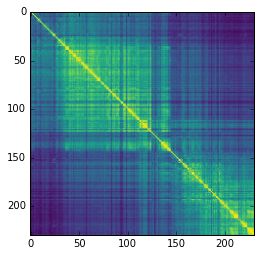

In [16]:
index_sou = similarities.MatrixSimilarity(corpus_lsi_sou)
sims_sou = np.array([index_sou[lsi_sou[corp]] for corp in corpus_sou])
plt.imshow(sims_sou,cmap=plt.cm.viridis)

In [19]:
import codecs, json

def write_json(sim,data,party):
    sim = sim.tolist()
    try:
        labels = map(lambda x : ' '.join([x[0],"({})".format(x[1][:3].lower()),str(x[2])]),zip(data['speaker'],data['party'],data['date']))
    except Exception:
        parties = ["" for i in range(len(data['text']))]
        labels = map(lambda x : ' '.join([x[0],"({})".format(x[1][:3].lower()),str(x[2])]),zip(data['speaker'],parties,data['date']))
    labels = map(lambda x : ', '.join([x[0],x[1]]),product(labels,labels))
    labels = np.array(labels).reshape(len(data['date']),len(data['date'])).tolist()
    fname = 'data_{}.json'.format(party)
    out = {'sims':sim,'labels':labels}
    json.dump(out, codecs.open(fname, 'w', encoding='utf-8'), separators=(',', ':'),indent=4)

In [21]:
write_json(sims,data,'all')
write_json(sims_con,data_con,'con')
write_json(sims_lab,data_lab,'lab')
write_json(sims_libdem,data_libdem,'libdem')
write_json(sims_sou,data_sou,'sou')

In [3]:
party_sou = pickle.load(open('../data/external/party.p'))

In [5]:
len(party_sou)

44

In [18]:
filter(lambda x : x[0] == 'Harry S. Truman', zip(data_sou['speaker'],range(len(data_sou['speaker']))))

[(u'Harry S. Truman', 156),
 (u'Harry S. Truman', 157),
 (u'Harry S. Truman', 158),
 (u'Harry S. Truman', 159),
 (u'Harry S. Truman', 160),
 (u'Harry S. Truman', 161),
 (u'Harry S. Truman', 162),
 (u'Harry S. Truman', 164)]

In [28]:
data_sou['date'][164]

1953